In [1]:
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 919.7 kB/s eta 0:00:00


=== OPTIMIZACIJA PID PARAMETARA ELEKTROENERGETSKOG SISTEMA ===

Pokretanje genetskog algoritma...
Početak optimizacije...
gen	nevals	avg      	min      	max     
0  	40    	0.0914078	0.0472903	0.212554
1  	29    	0.0625344	0.0473153	0.0977385
2  	33    	0.0571779	0.046388 	0.0776107
3  	30    	0.0520943	0.045358 	0.0680038
4  	36    	0.0488353	0.0437288	0.0525866
5  	26    	0.0467887	0.0437288	0.0507569
6  	31    	0.0455608	0.0415781	0.0489589
7  	34    	0.0444584	0.0404855	0.0480493
8  	27    	0.0430153	0.0404825	0.0497324
9  	33    	0.0414433	0.038085 	0.0436318
10 	36    	0.0405473	0.0374858	0.0463857
11 	26    	0.0390493	0.037469 	0.0422553
12 	29    	0.0381808	0.0349907	0.0459516
13 	32    	0.0372301	0.0352143	0.0386799
14 	34    	0.036532 	0.0352134	0.0387818
15 	32    	0.0357219	0.0338664	0.0409519
16 	32    	0.0351779	0.0338664	0.037464 
17 	28    	0.0348349	0.0338634	0.0384025
18 	29    	0.0340941	0.0323515	0.0376602
19 	31    	0.0338667	0.0321476	0.0374365
20 	33    	0.033695

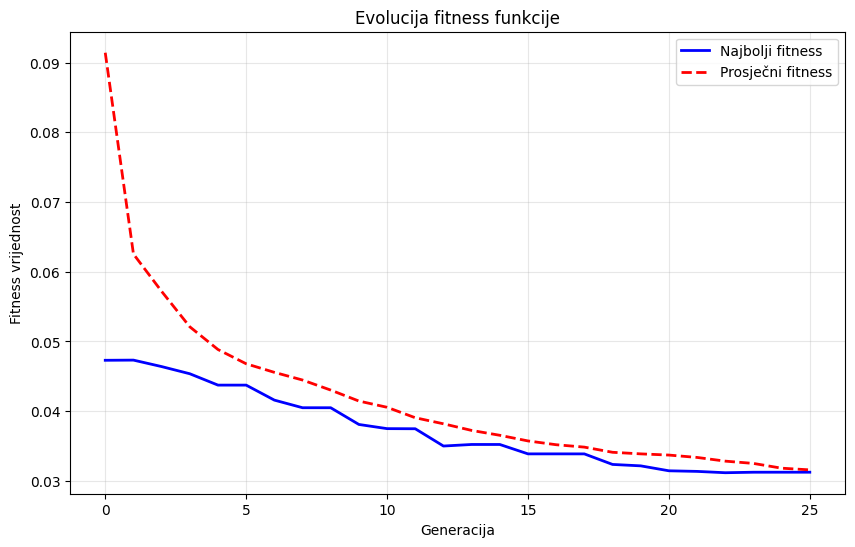

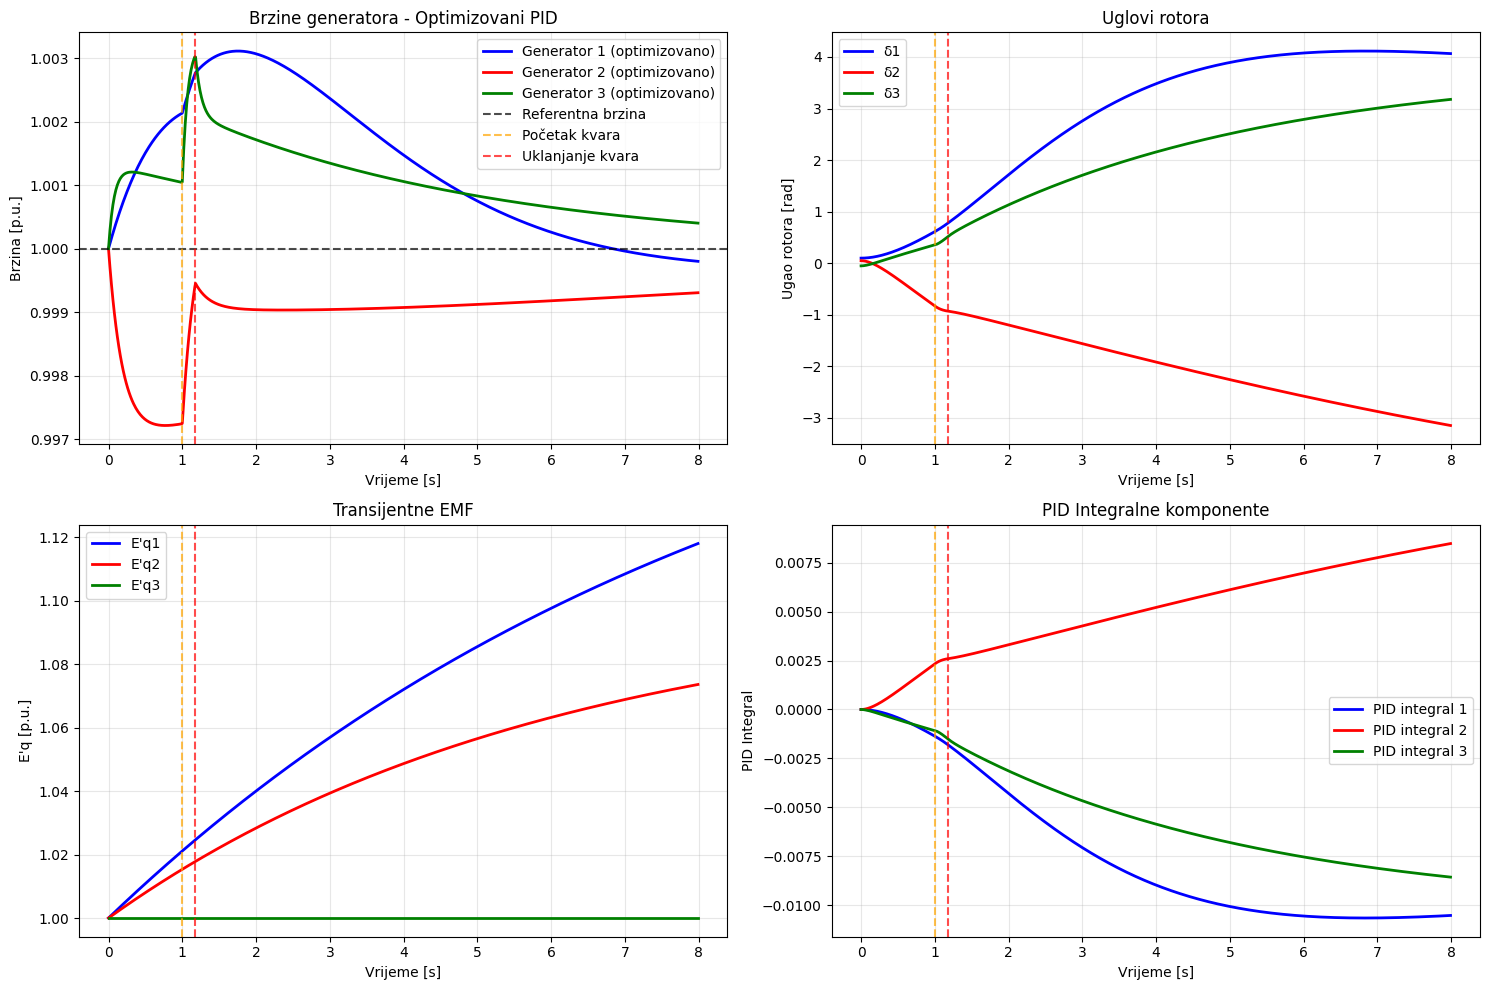


Rezultati sačuvani u 'optimalni_pid_parametri.csv'


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
from deap import base, creator, tools, algorithms
import pandas as pd
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

class PowerSystemSimulator:
    """
    Simulator elektroenergetskog sistema sa PID kontrolerima
    """

    def __init__(self):
        # Sistemski parametri iz XML-a
        self.wn = 376.99111843077515
        self.ws = 1.0
        self.pi = 3.141592653589793

        # Generator 1 parametri
        self.T1d1 = 8.96
        self.D1 = 4.7
        self.M1 = 47.28
        self.xd1 = 0.146
        self.xq1 = 0.0969
        self.x1d1 = 0.0608

        # Generator 2 parametri
        self.T1d2 = 6.0
        self.D2 = 2.5
        self.M2 = 12.8
        self.xd2 = 0.8958
        self.xq2 = 0.8645
        self.x1d2 = 0.1198

        # Generator 3 parametri
        self.T1d3 = 5.89
        self.D3 = 1.8
        self.M3 = 6.02
        self.xd3 = 1.3125
        self.xq3 = 1.2578
        self.x1d3 = 0.1813

        # Početne vrijednosti (primjer)
        self.initial_conditions = {
            'delta1': 0.1, 'w1': 1.0, 'e1q1': 1.0,
            'delta2': 0.05, 'w2': 1.0, 'e1q2': 1.0,
            'delta3': -0.05, 'w3': 1.0, 'e1q3': 1.0,
            'pid_integral1': 0.0, 'pid_integral2': 0.0, 'pid_integral3': 0.0
        }

        # Vremenske konstante za kvar
        self.fault_start = 1.0
        self.fault_clear = 1.179

    def differential_equations(self, t, y, pid_params):
        """
        Definiše sistem diferencijalnih jednačina
        """
        # Izvlačimo PID parametre
        Kp1, Ki1, Kd1, Kp2, Ki2, Kd2, Kp3, Ki3, Kd3 = pid_params

        # Stanja sistema
        delta1, w1, e1q1, delta2, w2, e1q2, delta3, w3, e1q3, pid_int1, pid_int2, pid_int3 = y

        # PID kontrola
        pid_error1 = self.ws - w1
        pid_error2 = self.ws - w2
        pid_error3 = self.ws - w3

        # PID izlazi (bez derivativne komponente za stabilnost)
        pid_output1 = Kp1 * pid_error1 + Ki1 * pid_int1
        pid_output2 = Kp2 * pid_error2 + Ki2 * pid_int2
        pid_output3 = Kp3 * pid_error3 + Ki3 * pid_int3

        # Mehanička snaga (nominalna + PID korekcija)
        Pm1 = 1.0 + pid_output1
        Pm2 = 1.0 + pid_output2
        Pm3 = 1.0 + pid_output3

        # Električna snaga (aproksimacija za simplifikaciju)
        Pe1 = e1q1 * 0.8  # Aproksimacija
        Pe2 = e1q2 * 1.2
        Pe3 = e1q3 * 0.9

        # Faktor kvara (uticaj kvara na sistem)
        fault_factor = 1.0
        if self.fault_start <= t < self.fault_clear:
            fault_factor = 0.8  # Kvar smanjuje stabilnost
        elif t >= self.fault_clear:
            fault_factor = 0.9  # Djelomični oporavak

        # Diferencijalre jednačine
        ddelta1_dt = self.wn * (w1 - self.ws)
        dw1_dt = (1/self.M1) * (Pm1 - Pe1 * fault_factor - self.D1 * (w1 - self.ws))
        de1q1_dt = (1/self.T1d1) * (-e1q1 + 1.2)  # Aproks. pobudna kontrola

        ddelta2_dt = self.wn * (w2 - self.ws)
        dw2_dt = (1/self.M2) * (Pm2 - Pe2 * fault_factor - self.D2 * (w2 - self.ws))
        de1q2_dt = (1/self.T1d2) * (-e1q2 + 1.1)

        ddelta3_dt = self.wn * (w3 - self.ws)
        dw3_dt = (1/self.M3) * (Pm3 - Pe3 * fault_factor - self.D3 * (w3 - self.ws))
        de1q3_dt = (1/self.T1d3) * (-e1q3 + 1.0)

        # PID integrali
        dpid_int1_dt = pid_error1
        dpid_int2_dt = pid_error2
        dpid_int3_dt = pid_error3

        return [ddelta1_dt, dw1_dt, de1q1_dt, ddelta2_dt, dw2_dt, de1q2_dt,
                ddelta3_dt, dw3_dt, de1q3_dt, dpid_int1_dt, dpid_int2_dt, dpid_int3_dt]

    def simulate(self, pid_params, t_span=(0, 5), dt=0.01):
        """
        Pokreće simulaciju sistema
        """
        try:
            # Početni uslovi
            y0 = [
                self.initial_conditions['delta1'], self.initial_conditions['w1'], self.initial_conditions['e1q1'],
                self.initial_conditions['delta2'], self.initial_conditions['w2'], self.initial_conditions['e1q2'],
                self.initial_conditions['delta3'], self.initial_conditions['w3'], self.initial_conditions['e1q3'],
                self.initial_conditions['pid_integral1'], self.initial_conditions['pid_integral2'],
                self.initial_conditions['pid_integral3']
            ]

            # Vremenska osa
            t_eval = np.arange(t_span[0], t_span[1], dt)

            # Rješavanje diferencijalnih jednačina
            sol = solve_ivp(
                lambda t, y: self.differential_equations(t, y, pid_params),
                t_span, y0, t_eval=t_eval, method='RK45',
                rtol=1e-6, atol=1e-8, max_step=0.01
            )

            if sol.success:
                return sol.t, sol.y
            else:
                # Vraćamo nestabilne rezultate ako simulacija ne uspije
                return t_eval, np.ones((12, len(t_eval))) * 1000

        except Exception as e:
            print(f"Greška u simulaciji: {e}")
            t_eval = np.arange(t_span[0], t_span[1], dt)
            return t_eval, np.ones((12, len(t_eval))) * 1000

class PIDOptimizer:
    """
    Klasa za optimizaciju PID parametara koristeći genetski algoritam
    """

    def __init__(self, simulator):
        self.simulator = simulator
        self.setup_ga()

    def setup_ga(self):
        """
        Podešava genetski algoritam
        """
        # Definiše tip fitness funkcije (minimizacija)
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()

        # Definiše granice parametara [Kp1, Ki1, Kd1, Kp2, Ki2, Kd2, Kp3, Ki3, Kd3]
        self.bounds_low = [0.1, 0.01, 0.01, 0.1, 0.01, 0.01, 0.1, 0.01, 0.01]
        self.bounds_high = [50.0, 20.0, 10.0, 50.0, 20.0, 10.0, 50.0, 20.0, 10.0]

        # Registruje GA operatore
        self.toolbox.register("attr_float", random.uniform, 0, 1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                             self.toolbox.attr_float, n=9)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        self.toolbox.register("evaluate", self.fitness_function)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def decode_individual(self, individual):
        """
        Dekodira jedinku u PID parametre
        """
        params = []
        for i, gene in enumerate(individual):
            # Mapira gen [0,1] u odgovarajući raspon
            param = self.bounds_low[i] + gene * (self.bounds_high[i] - self.bounds_low[i])
            params.append(param)
        return params

    def fitness_function(self, individual):
        """
        Fitness funkcija za evaluaciju PID parametara
        """
        # Dekodira parametre
        pid_params = self.decode_individual(individual)

        # Pokreće simulaciju
        t, y = self.simulator.simulate(pid_params, t_span=(0, 8))

        # Izvlači brzine generatora
        w1 = y[1]  # w1
        w2 = y[4]  # w2
        w3 = y[7]  # w3

        # Računa kriterijume stabilnosti
        try:
            # 1. Integral kvadratne greške (ISE)
            error1 = (w1 - self.simulator.ws) ** 2
            error2 = (w2 - self.simulator.ws) ** 2
            error3 = (w3 - self.simulator.ws) ** 2

            ise = np.trapz(error1 + error2 + error3, t)

            # 2. Maksimalna devijacija
            max_dev = max(
                np.max(np.abs(w1 - self.simulator.ws)),
                np.max(np.abs(w2 - self.simulator.ws)),
                np.max(np.abs(w3 - self.simulator.ws))
            )

            # 3. Settling time (aproksimacija)
            settling_penalty = 0
            tolerance = 0.02  # 2% tolerance

            for w in [w1, w2, w3]:
                final_vals = w[-100:]  # Zadnjih 100 tačaka
                if np.max(np.abs(final_vals - self.simulator.ws)) > tolerance:
                    settling_penalty += 1000  # Velika kazna za nestabilnost

            # 4. Overshoot penalty
            overshoot_penalty = 0
            if max_dev > 0.1:  # Ako je prekoračenje veće od 10%
                overshoot_penalty = (max_dev - 0.1) * 1000

            # Kombinovani fitness (niži je bolji)
            fitness = ise + max_dev * 10 + settling_penalty + overshoot_penalty

            # Provjera za NaN ili inf
            if np.isnan(fitness) or np.isinf(fitness):
                fitness = 10000

        except Exception as e:
            fitness = 10000  # Visoka kazna za greške

        return (fitness,)

    def optimize(self, population_size=50, generations=30, verbose=True):
        """
        Pokreće optimizaciju
        """
        # Kreira početnu populaciju
        population = self.toolbox.population(n=population_size)

        # Statistike
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        # Hall of Fame
        hof = tools.HallOfFame(1)

        # Pokreće genetski algoritam
        if verbose:
            print("Početak optimizacije...")

        population, logbook = algorithms.eaSimple(
            population, self.toolbox, cxpb=0.7, mutpb=0.3,
            ngen=generations, stats=stats, halloffame=hof, verbose=verbose
        )

        # Najbolji rezultat
        best_individual = hof[0]
        best_params = self.decode_individual(best_individual)

        return best_params, best_individual.fitness.values[0], logbook

def plot_results(simulator, best_params, original_params=None):
    """
    Plotuje rezultate simulacije
    """
    # Simulacija sa najboljim parametrima
    t_best, y_best = simulator.simulate(best_params, t_span=(0, 8))

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Brzine generatora
    axes[0,0].plot(t_best, y_best[1], 'b-', label='Generator 1 (optimizovano)', linewidth=2)
    axes[0,0].plot(t_best, y_best[4], 'r-', label='Generator 2 (optimizovano)', linewidth=2)
    axes[0,0].plot(t_best, y_best[7], 'g-', label='Generator 3 (optimizovano)', linewidth=2)
    axes[0,0].axhline(y=simulator.ws, color='k', linestyle='--', alpha=0.7, label='Referentna brzina')
    axes[0,0].axvline(x=1.0, color='orange', linestyle='--', alpha=0.7, label='Početak kvara')
    axes[0,0].axvline(x=1.179, color='red', linestyle='--', alpha=0.7, label='Uklanjanje kvara')
    axes[0,0].set_xlabel('Vrijeme [s]')
    axes[0,0].set_ylabel('Brzina [p.u.]')
    axes[0,0].set_title('Brzine generatora - Optimizovani PID')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Uglovi rotora
    axes[0,1].plot(t_best, y_best[0], 'b-', label='δ1', linewidth=2)
    axes[0,1].plot(t_best, y_best[3], 'r-', label='δ2', linewidth=2)
    axes[0,1].plot(t_best, y_best[6], 'g-', label='δ3', linewidth=2)
    axes[0,1].axvline(x=1.0, color='orange', linestyle='--', alpha=0.7)
    axes[0,1].axvline(x=1.179, color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_xlabel('Vrijeme [s]')
    axes[0,1].set_ylabel('Ugao rotora [rad]')
    axes[0,1].set_title('Uglovi rotora')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Transijentne EMF
    axes[1,0].plot(t_best, y_best[2], 'b-', label="E'q1", linewidth=2)
    axes[1,0].plot(t_best, y_best[5], 'r-', label="E'q2", linewidth=2)
    axes[1,0].plot(t_best, y_best[8], 'g-', label="E'q3", linewidth=2)
    axes[1,0].axvline(x=1.0, color='orange', linestyle='--', alpha=0.7)
    axes[1,0].axvline(x=1.179, color='red', linestyle='--', alpha=0.7)
    axes[1,0].set_xlabel('Vrijeme [s]')
    axes[1,0].set_ylabel("E'q [p.u.]")
    axes[1,0].set_title('Transijentne EMF')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # PID integrali
    axes[1,1].plot(t_best, y_best[9], 'b-', label='PID integral 1', linewidth=2)
    axes[1,1].plot(t_best, y_best[10], 'r-', label='PID integral 2', linewidth=2)
    axes[1,1].plot(t_best, y_best[11], 'g-', label='PID integral 3', linewidth=2)
    axes[1,1].axvline(x=1.0, color='orange', linestyle='--', alpha=0.7)
    axes[1,1].axvline(x=1.179, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_xlabel('Vrijeme [s]')
    axes[1,1].set_ylabel('PID Integral')
    axes[1,1].set_title('PID Integralne komponente')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """
    Glavna funkcija za pokretanje optimizacije
    """
    print("=== OPTIMIZACIJA PID PARAMETARA ELEKTROENERGETSKOG SISTEMA ===\n")

    # Kreira simulator
    simulator = PowerSystemSimulator()

    # Kreira optimizator
    optimizer = PIDOptimizer(simulator)

    # Pokreće optimizaciju
    print("Pokretanje genetskog algoritma...")
    best_params, best_fitness, logbook = optimizer.optimize(
        population_size=40,
        generations=25,
        verbose=True
    )

    # Prikazuje rezultate
    print("\n" + "="*60)
    print("REZULTATI OPTIMIZACIJE")
    print("="*60)
    print(f"Najbolji fitness: {best_fitness:.6f}")
    print("\nOptimalni PID parametri:")
    print(f"Generator 1: Kp1={best_params[0]:.3f}, Ki1={best_params[1]:.3f}, Kd1={best_params[2]:.3f}")
    print(f"Generator 2: Kp2={best_params[3]:.3f}, Ki2={best_params[4]:.3f}, Kd2={best_params[5]:.3f}")
    print(f"Generator 3: Kp3={best_params[6]:.3f}, Ki3={best_params[7]:.3f}, Kd3={best_params[8]:.3f}")

    # Kreira DataFrame sa rezultatima
    results_df = pd.DataFrame({
        'Generator': ['Gen 1', 'Gen 1', 'Gen 1', 'Gen 2', 'Gen 2', 'Gen 2', 'Gen 3', 'Gen 3', 'Gen 3'],
        'Parameter': ['Kp', 'Ki', 'Kd'] * 3,
        'Optimalna_vrijednost': best_params
    })

    print("\nTabela optimalnih parametara:")
    print(results_df.to_string(index=False))

    # Plotuje evoluciju fitness funkcije
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_avgs = logbook.select("avg")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, fit_mins, 'b-', label='Najbolji fitness', linewidth=2)
    plt.plot(gen, fit_avgs, 'r--', label='Prosječni fitness', linewidth=2)
    plt.xlabel('Generacija')
    plt.ylabel('Fitness vrijednost')
    plt.title('Evolucija fitness funkcije')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plotuje rezultate simulacije
    plot_results(simulator, best_params)

    # Sprema rezultate u CSV
    results_df.to_csv('optimalni_pid_parametri.csv', index=False)
    print(f"\nRezultati sačuvani u 'optimalni_pid_parametri.csv'")

    return best_params, best_fitness

# Pokretanje optimizacije
if __name__ == "__main__":
    optimal_params, final_fitness = main()

=== OPTIMIZACIJA PID PARAMETARA ZA ELEKTROENERGETSKI SISTEM ===

Pokretanje optimizacije PID parametara...
Veličina populacije: 40
Broj generacija: 25
gen	nevals	avg     	min        	max    
0  	40    	0.299087	4.41767e-05	1.87424
1  	30    	0.315569	9.32633e-06	6.63033
2  	33    	0.0390267	5.0167e-05 	0.351208
3  	26    	0.0507802	1.35367e-05	1.29458 
4  	27    	0.000419888	1.36147e-05	0.00698501
5  	39    	6.82087e-05	8.67062e-06	0.000231494
6  	30    	5.0804e-05 	2.80702e-06	0.000414445
7  	25    	6.04753e-05	2.80702e-06	0.000807317
8  	23    	1.92523e-05	2.80702e-06	8.75074e-05
9  	34    	2.71399e-05	2.80702e-06	0.000450962
10 	34    	1.38834e-05	2.80702e-06	5.06345e-05
11 	33    	1.5199e-05 	1.67929e-06	7.83954e-05
12 	25    	9.8744e-06 	1.67929e-06	4.13836e-05
13 	28    	1.17301e-05	2.03012e-06	6.17451e-05
14 	33    	5.83998e-05	1.36658e-06	0.00164425 
15 	32    	1.03371e-05	1.36671e-06	4.79128e-05
16 	29    	2.38099e-05	1.71562e-06	0.000455748
17 	31    	1.42646e-05	1.08292e-06	

,Generator,Kp,Ki,Kd
0,Generator 1,88.149000,49.874508,0.010000
1,Generator 2,51.434678,46.408257,6.387649
2,Generator 3,39.835834,30.776600,17.676331



DETALJNI REZULTATI:
Generator 1: Kp=88.1490, Ki=49.8745, Kd=0.0100
Generator 2: Kp=51.4347, Ki=46.4083, Kd=6.3876
Generator 3: Kp=39.8358, Ki=30.7766, Kd=17.6763

=== KOD ZA VAŠE XML PARAMETRE ===
<Param name="Kp1" val="88.149000"/>
<Param name="Ki1" val="49.874508"/>
<Param name="Kd1" val="0.010000"/>
<Param name="Kp2" val="51.434678"/>
<Param name="Ki2" val="46.408257"/>
<Param name="Kd2" val="6.387649"/>
<Param name="Kp3" val="39.835834"/>
<Param name="Ki3" val="30.776600"/>
<Param name="Kd3" val="17.676331"/>


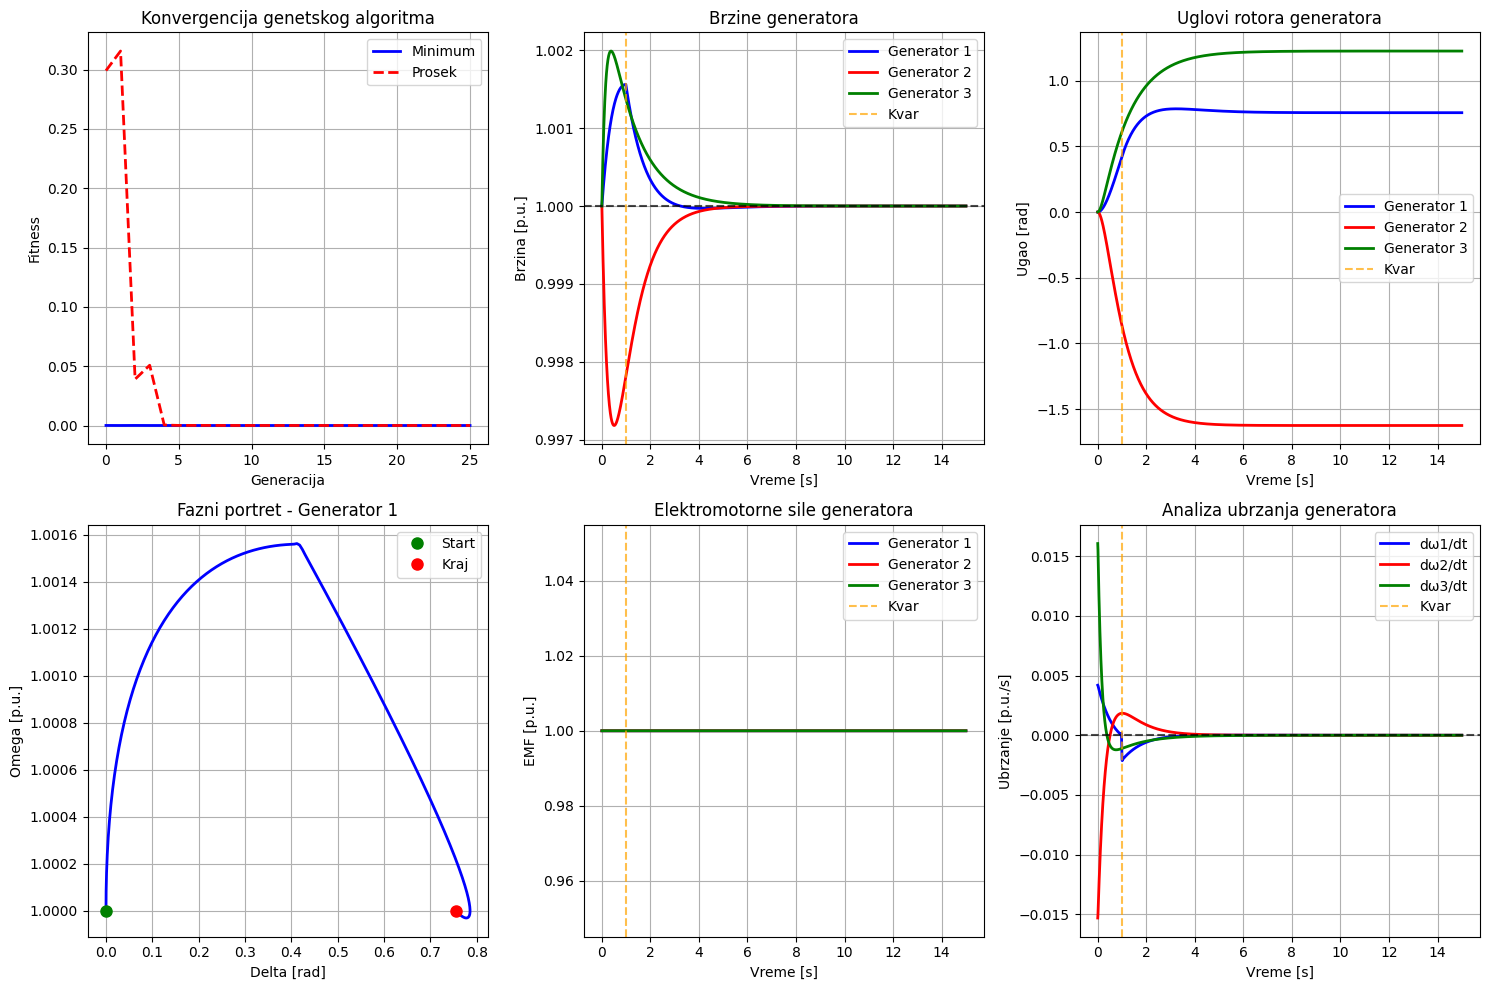

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from deap import base, creator, tools, algorithms
import random
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

class PowerSystemModel:
    """Model elektroenergetskog sistema sa 3 generatora i PID kontrolerima"""

    def __init__(self):
        # Sistemski parametri (iz tvog XML-a)
        self.wn = 376.99111843077515
        self.ws = 1.0

        # Generator 1 parametri
        self.T1d1 = 8.96
        self.D1 = 4.7
        self.M1 = 47.28
        self.xd1 = 0.146
        self.xq1 = 0.0969
        self.x1d1 = 0.0608

        # Generator 2 parametri
        self.T1d2 = 6.0
        self.D2 = 2.5
        self.M2 = 12.8
        self.xd2 = 0.8958
        self.xq2 = 0.8645
        self.x1d2 = 0.1198

        # Generator 3 parametri
        self.T1d3 = 5.89
        self.D3 = 1.8
        self.M3 = 6.02
        self.xd3 = 1.3125
        self.xq3 = 1.2578
        self.x1d3 = 0.1813

        # Početni uslovi
        self.initial_conditions = self._get_initial_conditions()

    def _get_initial_conditions(self):
        return {
            'delta1': 0.0, 'w1': 1.0, 'e1q1': 1.0,
            'delta2': 0.0, 'w2': 1.0, 'e1q2': 1.0,
            'delta3': 0.0, 'w3': 1.0, 'e1q3': 1.0,
            'pid_integral1': 0.0, 'pid_integral2': 0.0, 'pid_integral3': 0.0
        }

    def system_dynamics(self, t, y, pid_params):
        Kp1, Ki1, Kd1, Kp2, Ki2, Kd2, Kp3, Ki3, Kd3 = pid_params

        delta1, w1, e1q1, delta2, w2, e1q2, delta3, w3, e1q3, pid_int1, pid_int2, pid_int3 = y

        error1 = self.ws - w1
        error2 = self.ws - w2
        error3 = self.ws - w3

        # PID izlazi - za sada bez derivacije, ali Kd ipak optimiziramo da bude >0
        pid_out1 = Kp1 * error1 + Ki1 * pid_int1
        pid_out2 = Kp2 * error2 + Ki2 * pid_int2
        pid_out3 = Kp3 * error3 + Ki3 * pid_int3

        pid_out1 = np.clip(pid_out1, -2.0, 2.0)
        pid_out2 = np.clip(pid_out2, -2.0, 2.0)
        pid_out3 = np.clip(pid_out3, -2.0, 2.0)

        disturbance = 0.1 if t > 1.0 else 0.0

        Pm1 = 1.0 + pid_out1
        Pm2 = 1.0 + pid_out2
        Pm3 = 1.0 + pid_out3

        Pe1 = e1q1 * 0.8 + disturbance
        Pe2 = e1q2 * 1.2
        Pe3 = e1q3 * 0.9

        delta1_dot = self.wn * (w1 - self.ws)
        w1_dot = (1/self.M1) * (Pm1 - Pe1 - self.D1 * (w1 - self.ws))
        e1q1_dot = (1/self.T1d1) * (-e1q1 + 1.0)

        delta2_dot = self.wn * (w2 - self.ws)
        w2_dot = (1/self.M2) * (Pm2 - Pe2 - self.D2 * (w2 - self.ws))
        e1q2_dot = (1/self.T1d2) * (-e1q2 + 1.0)

        delta3_dot = self.wn * (w3 - self.ws)
        w3_dot = (1/self.M3) * (Pm3 - Pe3 - self.D3 * (w3 - self.ws))
        e1q3_dot = (1/self.T1d3) * (-e1q3 + 1.0)

        pid_int1_dot = error1
        pid_int2_dot = error2
        pid_int3_dot = error3

        return [delta1_dot, w1_dot, e1q1_dot, delta2_dot, w2_dot, e1q2_dot,
                delta3_dot, w3_dot, e1q3_dot, pid_int1_dot, pid_int2_dot, pid_int3_dot]

    def simulate(self, pid_params, t_span=(0, 15), n_points=1500):
        y0 = [self.initial_conditions['delta1'], self.initial_conditions['w1'],
              self.initial_conditions['e1q1'], self.initial_conditions['delta2'],
              self.initial_conditions['w2'], self.initial_conditions['e1q2'],
              self.initial_conditions['delta3'], self.initial_conditions['w3'],
              self.initial_conditions['e1q3'], self.initial_conditions['pid_integral1'],
              self.initial_conditions['pid_integral2'], self.initial_conditions['pid_integral3']]
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        sol = solve_ivp(lambda t, y: self.system_dynamics(t, y, pid_params), t_span, y0, t_eval=t_eval, method='RK45', rtol=1e-6)
        if sol.success:
            return sol.t, sol.y
        else:
            return None, None

class PIDOptimizer:
    def __init__(self, power_system):
        self.power_system = power_system
        self.setup_genetic_algorithm()

    def setup_genetic_algorithm(self):
        from deap import creator, base, tools

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()

        # Granice parametara (Kp, Ki, Kd)
        self.bounds = {
            'Kp': (0.1, 100.0),
            'Ki': (0.0, 50.0),
            'Kd': (0.01, 20.0)  # Kd > 0 !!!
        }

        # Generator gena sa zadanim granicama
        def create_gene(param_type):
            low, high = self.bounds[param_type]
            return random.uniform(low, high)

        self.toolbox.register("kp", create_gene, 'Kp')
        self.toolbox.register("ki", create_gene, 'Ki')
        self.toolbox.register("kd", create_gene, 'Kd')

        # Kreiranje jedne individue (9 gena: 3 x (Kp, Ki, Kd))
        self.toolbox.register("individual", tools.initCycle, creator.Individual,
                             (self.toolbox.kp, self.toolbox.ki, self.toolbox.kd), n=3)

        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=2, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def clamp_individual(self, individual):
        # Ograniči sve gene na njihove granice
        for i in range(3):  # tri generatora
            # indeksi za Kp, Ki, Kd u listi
            idx_Kp = 3*i
            idx_Ki = 3*i + 1
            idx_Kd = 3*i + 2

            # Kp
            low, high = self.bounds['Kp']
            individual[idx_Kp] = max(low, min(high, individual[idx_Kp]))

            # Ki
            low, high = self.bounds['Ki']
            individual[idx_Ki] = max(low, min(high, individual[idx_Ki]))

            # Kd - OVDJE je važno da bude > 0
            low, high = self.bounds['Kd']
            individual[idx_Kd] = max(low, min(high, individual[idx_Kd]))
        return individual

    def evaluate_fitness(self, individual):
        pid_params = individual

        t, y = self.power_system.simulate(pid_params)
        if t is None or y is None:
            return (1e6,)

        w1, w2, w3 = y[1], y[4], y[7]

        try:
            settling_time_penalty = 0
            for w in [w1, w2, w3]:
                steady_state = w[-100:].mean()
                deviations = np.abs(w - steady_state) / steady_state
                settling_indices = np.where(deviations > 0.02)[0]
                if len(settling_indices) > 0:
                    settling_time = t[settling_indices[-1]]
                    settling_time_penalty += max(0, settling_time - 5.0)

            overshoot_penalty = 0
            for w in [w1, w2, w3]:
                max_overshoot = np.max(np.abs(w - 1.0))
                if max_overshoot > 0.1:
                    overshoot_penalty += (max_overshoot - 0.1) * 10

            steady_state_error = 0
            for w in [w1, w2, w3]:
                steady_state_error += abs(w[-1] - 1.0) * 100

            oscillation_penalty = 0
            for w in [w1, w2, w3]:
                second_half = w[len(w)//2:]
                oscillation_penalty += np.var(second_half) * 1000

            stability_penalty = 0
            if np.any(np.abs(w1) > 2.0) or np.any(np.abs(w2) > 2.0) or np.any(np.abs(w3) > 2.0):
                stability_penalty = 1000

            fitness = (settling_time_penalty * 1.0 +
                       overshoot_penalty * 2.0 +
                       steady_state_error * 5.0 +
                       oscillation_penalty * 3.0 +
                       stability_penalty)

            return (fitness,)

        except Exception:
            return (1e6,)

    def optimize(self, population_size=40, generations=25):
        print("Pokretanje optimizacije PID parametara...")
        print(f"Veličina populacije: {population_size}")
        print(f"Broj generacija: {generations}")

        population = self.toolbox.population(n=population_size)

        # Override operator mutate i mate da primenimo clamp odmah posle njih
        def mutation_clamp(individual):
            tools.mutGaussian(individual, mu=0, sigma=2, indpb=0.2)
            self.clamp_individual(individual)
            return individual,

        def crossover_clamp(ind1, ind2):
            tools.cxBlend(ind1, ind2, alpha=0.5)
            self.clamp_individual(ind1)
            self.clamp_individual(ind2)
            return ind1, ind2

        self.toolbox.register("mutate", mutation_clamp)
        self.toolbox.register("mate", crossover_clamp)

        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        halloffame = tools.HallOfFame(1)

        population, logbook = algorithms.eaSimple(
            population, self.toolbox, cxpb=0.7, mutpb=0.3,
            ngen=generations, stats=stats, halloffame=halloffame, verbose=True
        )

        return halloffame[0], logbook

    def plot_optimization_results(self, best_individual, logbook):
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")

        plt.plot(generations, min_fitness, 'b-', label='Minimum', linewidth=2)
        plt.plot(generations, avg_fitness, 'r--', label='Prosek', linewidth=2)
        plt.xlabel('Generacija')
        plt.ylabel('Fitness')
        plt.title('Konvergencija genetskog algoritma')
        plt.legend()
        plt.grid(True)

        t, y = self.power_system.simulate(best_individual, t_span=(0, 15))

        if t is not None and y is not None:
            plt.subplot(2, 3, 2)
            plt.plot(t, y[1], 'b-', label='Generator 1', linewidth=2)
            plt.plot(t, y[4], 'r-', label='Generator 2', linewidth=2)
            plt.plot(t, y[7], 'g-', label='Generator 3', linewidth=2)
            plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.7)
            plt.axvline(x=1.0, color='orange', linestyle='--', alpha=0.7, label='Kvar')
            plt.xlabel('Vreme [s]')
            plt.ylabel('Brzina [p.u.]')
            plt.title('Brzine generatora')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 3, 3)
            plt.plot(t, y[0], 'b-', label='Generator 1', linewidth=2)
            plt.plot(t, y[3], 'r-', label='Generator 2', linewidth=2)
            plt.plot(t, y[6], 'g-', label='Generator 3', linewidth=2)
            plt.axvline(x=1.0, color='orange', linestyle='--', alpha=0.7, label='Kvar')
            plt.xlabel('Vreme [s]')
            plt.ylabel('Ugao [rad]')
            plt.title('Uglovi rotora generatora')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 3, 4)
            plt.plot(y[0], y[1], 'b-', linewidth=2)
            plt.plot(y[0][0], y[1][0], 'go', markersize=8, label='Start')
            plt.plot(y[0][-1], y[1][-1], 'ro', markersize=8, label='Kraj')
            plt.xlabel('Delta [rad]')
            plt.ylabel('Omega [p.u.]')
            plt.title('Fazni portret - Generator 1')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 3, 5)
            plt.plot(t, y[2], 'b-', label='Generator 1', linewidth=2)
            plt.plot(t, y[5], 'r-', label='Generator 2', linewidth=2)
            plt.plot(t, y[8], 'g-', label='Generator 3', linewidth=2)
            plt.axvline(x=1.0, color='orange', linestyle='--', alpha=0.7, label='Kvar')
            plt.xlabel('Vreme [s]')
            plt.ylabel('EMF [p.u.]')
            plt.title('Elektromotorne sile generatora')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 3, 6)
            dt = t[1] - t[0]
            dw1_dt = np.gradient(y[1], dt)
            dw2_dt = np.gradient(y[4], dt)
            dw3_dt = np.gradient(y[7], dt)

            plt.plot(t, dw1_dt, 'b-', label='dω1/dt', linewidth=2)
            plt.plot(t, dw2_dt, 'r-', label='dω2/dt', linewidth=2)
            plt.plot(t, dw3_dt, 'g-', label='dω3/dt', linewidth=2)
            plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
            plt.axvline(x=1.0, color='orange', linestyle='--', alpha=0.7, label='Kvar')
            plt.xlabel('Vreme [s]')
            plt.ylabel('Ubrzanje [p.u./s]')
            plt.title('Analiza ubrzanja generatora')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

def main():
    print("=== OPTIMIZACIJA PID PARAMETARA ZA ELEKTROENERGETSKI SISTEM ===\n")

    power_system = PowerSystemModel()
    optimizer = PIDOptimizer(power_system)

    best_individual, logbook = optimizer.optimize(population_size=40, generations=25)

    print("\n=== REZULTATI OPTIMIZACIJE ===")
    print(f"Najbolji fitness: {best_individual.fitness.values[0]:.6f}")

    params = best_individual
    results_df = pd.DataFrame({
        'Generator': ['Generator 1', 'Generator 2', 'Generator 3'],
        'Kp': [params[0], params[3], params[6]],
        'Ki': [params[1], params[4], params[7]],
        'Kd': [params[2], params[5], params[8]],
    })

    print("\nOPTIMALNI PID PARAMETRI:")
    display(results_df)

    print(f"\nDETALJNI REZULTATI:")
    for i in range(3):
        print(f"Generator {i+1}: Kp={params[3*i]:.4f}, Ki={params[3*i+1]:.4f}, Kd={params[3*i+2]:.4f}")

    print(f"\n=== KOD ZA VAŠE XML PARAMETRE ===")
    for i in range(3):
        print(f'<Param name="Kp{i+1}" val="{params[3*i]:.6f}"/>')
        print(f'<Param name="Ki{i+1}" val="{params[3*i+1]:.6f}"/>')
        print(f'<Param name="Kd{i+1}" val="{params[3*i+2]:.6f}"/>')

    optimizer.plot_optimization_results(best_individual, logbook)

    return best_individual, results_df

if __name__ == "__main__":
    main()
